In [1]:
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt
import json
import seaborn as sns
from copy import deepcopy
%matplotlib inline

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
1.19.2
1.1.3


In [2]:
# Load PIRUS Data
pirus = pd.read_csv('../data/clean_data/pirus_deep_clean_Final.csv')

# Load PIRUS Codebook
with open('../data/clean_data/pirus_codebook.json') as f:
    pirus_codebook = json.load(f)

# Load Custom Color Map
cmap = ['#DBB03B', '#EEAD9A','#E7E3DF', '#965341', '#3186A9', '#66759A']
sns.set_palette(sns.color_palette(cmap))
sns.color_palette(cmap)

[(0.8588235294117647, 0.6901960784313725, 0.23137254901960785),
 (0.9333333333333333, 0.6784313725490196, 0.6039215686274509),
 (0.9058823529411765, 0.8901960784313725, 0.8745098039215686),
 (0.5882352941176471, 0.3254901960784314, 0.2549019607843137),
 (0.19215686274509805, 0.5254901960784314, 0.6627450980392157),
 (0.4, 0.4588235294117647, 0.6039215686274509)]

In [3]:
# Load relevant pirus columns into new DataFrame
ethnic_groups = pirus[['broad_ethnicity','terrorist_group_name1','subject_id', 'extent_plot', 'violent']]

# Filter ethnic_groups by violent
ethnic_groups = ethnic_groups.loc[ethnic_groups.violent == 1]
ethnic_groups.drop('violent', axis = 1, inplace = True)

# Drop any rows with NaN values (1688 rows remaining in ethnic groups)
ethnic_groups = ethnic_groups.dropna()
                 
# Count instances of terrorist groups
group_count = ethnic_groups['subject_id'].groupby(ethnic_groups['terrorist_group_name1']).count().to_frame(name = "instance_count")

# To be a terrorist group, it must have at least 3 members in the data
valid_groups = group_count.loc[group_count['instance_count'] >=3].index.to_list()

# Filter ethnic_groups for only valid groups (1635 rows remaining in ethnic groups)
ethnic_groups = ethnic_groups.loc[ethnic_groups['terrorist_group_name1'].isin(valid_groups)]

# Get number of unique ethnicities in each terrorist group
ethnic_group_groups = ethnic_groups['broad_ethnicity'].groupby([ethnic_groups['terrorist_group_name1']]).apply(lambda x: len(x.unique())).to_frame()

# Get all single ethnicity groups
single_ethnicity_groups = ethnic_group_groups.loc[(ethnic_group_groups['broad_ethnicity'] == 1)]
single_ethnicity_groups = single_ethnicity_groups.index

# Get all multi ethnicity groups
multi_ethnic_groups = ethnic_group_groups.loc[(ethnic_group_groups['broad_ethnicity'] >= 2)]
multi_ethnic_groups = multi_ethnic_groups.index.drop('-88')

In [4]:
def quasi_dummy_builder(x):
    if x in single_ethnicity_groups:
        return 1
    elif x in multi_ethnic_groups:
        return 2
    else:
        return 0
    
# Add new variable to ethnic groups representing whether the group is multi ethic or single
ethnic_groups['quasi_dummy'] = ethnic_groups['terrorist_group_name1'].apply(quasi_dummy_builder)

# Drop all instances of 0 in quasi_dummy (904 rows remain)
ethnic_groups = ethnic_groups.loc[(ethnic_groups['quasi_dummy'] != 0)]

In [5]:
# Map broad ethnicity codes to broad ethnicity variable
broad_ethnicity_codes = pirus_codebook['broad_ethnicity']['codes']
ethnic_groups['broad_ethnicity'] = ethnic_groups['broad_ethnicity'].apply(lambda x: broad_ethnicity_codes[(str(int(x)))])

In [6]:
# Get breakdown of ethnicity composition for single ethnicity groups
seg = ethnic_groups.loc[ethnic_groups['quasi_dummy'] == 1]
seg['subject_id'].groupby([seg['broad_ethnicity'], seg['terrorist_group_name1']]).apply(lambda x:'').to_frame(name = '')

broad_ethnicity              terrorist_group_name1                               
Black/African-American       Black Liberation Army                               
                             New Afrikan Freedom Fighters                        
Hispanic/Latino              Los Macheteros                                      
Middle Eastern/North African Hamas                                               
White                        Alaska Peacemakers Militia                          
                             Army of God                                         
                             Aryan Brotherhood                                   
                             Aryan Nations                                       
                             Aryan Republican Army                               
                             Forever Enduring Always Ready (FEAR)                
                             Hammerskin Nation                                   
                             Montana Freemen                                     
                             National Alliance                                   
                             Project 7                                           
                             Republic of Texas                                   
                             Rise Above Movement (R.A.M or RAM)                  
                             Sovereign Citizens                                  
                             The Covenant, The Sword, and the Arm of the Lor...  
                             The Order (Silent Brotherhood)                      
                             The Order II (Bruder Schweigen Strike Force II)     
                             The United Freedom Front (UFF)                      
                             Vinlanders Social Club                              
                             White Aryan Resistance                              
                             White Rabbit Three Percent Illinois Patriot Fre...  
                             World Church of the Creator                         
                             al-Qaeda (unspecified)

In [7]:
# Get ethnicity groups in each multi ethnicity group
pd.set_option('display.max_rows', 1000)
meg = ethnic_groups.loc[ethnic_groups['quasi_dummy'] == 2]
meg['subject_id'].groupby([meg['terrorist_group_name1'], meg['broad_ethnicity']]).apply(lambda x:'').to_frame(name = '')

terrorist_group_name1                       broad_ethnicity                                
Al-Qaeda in Iraq                            Middle Eastern/North African                   
                                            White                                          
Armed Forces of National Liberation (FALN)  Black/African-American                         
                                            Hispanic/Latino                                
Islamic State of Iraq and the Levant (ISIL) Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Hispanic/Latino                                
                                            Middle Eastern/North African                   
                                            White                                          
Jabhat al-Nusra                             Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Middle Eastern/North African                   
                                            White                                          
Jamiyyat Ul-Islam Is-Saheeh (JIS)           Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Hispanic/Latino                                
Jewish Defense League (JDL)                 Middle Eastern/North African                   
                                            White                                          
Ku Klux Klan                                Black/African-American                         
                                            White                                          
Lashkar-e Tayyiba (LeT)                     Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Middle Eastern/North African                   
                                            White                                          
Omega-7                                     Black/African-American                         
                                            Hispanic/Latino                                
Taliban                                     Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Hispanic/Latino                                
                                            Middle Eastern/North African                   
                                            White                                          
Tehrik-i-Taliban Pakistan (TTP)             Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Middle Eastern/North African                   
al-Qaeda core                               Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            Hispanic/Latino                                
                                            Middle Eastern/North African                   
                                            Native American                                
                                            White                                          
al-Qaeda in the Arabian Peninsula (AQAP)    Asian (incl. Iran, Afghanistan, and Pakistan)  
                                            Black/African-American                         
                                            

In [8]:
# Get break down of # of ethnic groups by e
ethnic_extent = ethnic_groups[['subject_id','extent_plot','quasi_dummy']]

# Count subject_id by, extent_plot & quasi_dummy
ethnic_extent_groups = ethnic_extent['subject_id'].groupby([ethnic_extent['extent_plot'], ethnic_extent['quasi_dummy']]).count().unstack().T

# Get Total for each index
ethnic_extent_groups['total plots'] = ethnic_extent_groups.sum(axis = 1)
ethnic_percent = deepcopy(ethnic_extent_groups)

# Get Pecentage of plots for each extent plot by quasi_dummy
ethnic_percent[0.0] = ethnic_percent[0.0]/ethnic_percent['total plots']*100
ethnic_percent[1.0] = ethnic_percent[1.0]/ethnic_percent['total plots']*100
ethnic_percent[2.0] = ethnic_percent[2.0]/ethnic_percent['total plots']*100
ethnic_percent[3.0] = ethnic_percent[3.0]/ethnic_percent['total plots']*100
ethnic_percent[4.0] = ethnic_percent[4.0]/ethnic_percent['total plots']*100
ethnic_percent[5.0] = ethnic_percent[5.0]/ethnic_percent['total plots']*100
ethnic_percent.drop('total plots', axis = 1, inplace = True)
ethnic_percent = ethnic_percent.reset_index()

# Melt unstacked data frame (ethnic_extent_groups) & Sort
ethnic_extent_groups = pd.melt(ethnic_percent, 
                               id_vars=['quasi_dummy'], 
                               value_vars=[0.0,1.0,2.0,3.0,4.0,5.0], ignore_index=False)
ethnic_extent_groups = ethnic_extent_groups.sort_values('extent_plot', ascending = False)

# Map variables codes to ethnic_extent_groups
dummy_codes = {1:'Single Ethnicity', 2:'Multi Ethnicity'}
ethnic_extent_groups['quasi_dummy'] = ethnic_extent_groups['quasi_dummy'].apply(lambda x: dummy_codes[x])

# Map extent plot codes to data frame
extent_codes = {'-99': 'Unknown',
                '5': 'Successful',
                '4': 'Attempted and failed',
                '3': 'Acquired materials',
                '2': 'Attempted to acquire materials',
                '1': 'Threatened Plot',
                '0': 'No plot'}
ethnic_extent_groups['extent_plot']=ethnic_extent_groups['extent_plot'].apply(lambda x:extent_codes[str(int(x))])
ethnic_extent_groups

,quasi_dummy,extent_plot,value
0,Single Ethnicity,Successful,50.510204
1,Multi Ethnicity,Successful,20.270270
0,Single Ethnicity,Attempted and failed,7.653061
1,Multi Ethnicity,Attempted and failed,8.918919
0,Single Ethnicity,Acquired materials,12.755102
1,Multi Ethnicity,Acquired materials,13.513514
0,Single Ethnicity,Attempted to acquire materials,4.081633
1,Multi Ethnicity,Attempted to acquire materials,4.864865
0,Single Ethnicity,Threatened Plot,6.122449
1,Multi Ethnicity,Threatened Plot,10.540541


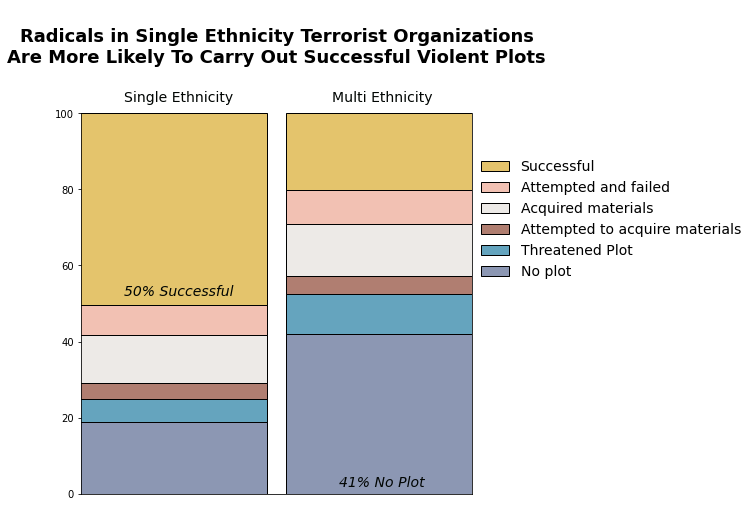

In [9]:
# Plot figure
fig, ax = plt.subplots(figsize = (7,7))

sns.histplot(ethnic_extent_groups, x = 'quasi_dummy', 
             hue = 'extent_plot', weights='value', 
             palette = cmap, multiple='stack', 
             shrink=.95, legend=True)

# Set title
title = '''
Radicals in Single Ethnicity Terrorist Organizations
Are More Likely To Carry Out Successful Violent Plots
'''

ax.set_title(title, weight='bold',
             loc = 'center', pad = 30).set_fontsize('18')

# Modify spines
ax.spines['top'].set_visible(False)

# Set y axis
ax.set(ylim = (0,100))
ax.set_ylabel("")

# Set x axis 
ax.set_xlabel("", fontsize = 14)
ax.set(xlim = (0,1))
ax.set_xticks('bottom')

# Move Legend
old_legend = ax.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
ax.legend(handles, labels, loc=(1.01,.55), frameon = False, fontsize = 14)

# Add annotations
annote1 = 'Single Ethnicity'
plt.text(.25, 103, annote1, horizontalalignment='center', size=14, color='#010503', weight='normal')

annote2 = 'Multi Ethnicity'
plt.text(.77, 103, annote2, horizontalalignment='center', size=14, color='#010503', weight='normal')

annote3 = '50% Successful'
plt.text(.25, 52, annote3, horizontalalignment='center', size=14, color='#010503', weight='normal', style = 'oblique')

annote4 = '41% No Plot'
plt.text(.77, 2, annote4, horizontalalignment='center', size=14, color='#010503', weight='normal', style = 'oblique')

# Show Figure
plt.show()